In [3]:
import pandas as pd
import numpy as np
import os
from Store_Sales.utils import *
from Store_Sales.constants import *

In [4]:
pwd

'd:\\projects\\store_sales\\Store_Sales_Ml_Project\\notebooks'

In [5]:
os.chdir("../")

In [6]:
pwd

'd:\\projects\\store_sales\\Store_Sales_Ml_Project'

In [7]:
from Store_Sales.utils import *
from Store_Sales.constants import *

In [8]:
test = pd.read_csv(TEST_FILE_PATH)
train=pd.read_csv(TRAIN_FILE_PATH)

In [9]:
na_column_train=[(i,train[i].isnull().sum()) for i in train.columns if train[i].isnull().sum()>0 ]
na_column_test=[(i,test[i].isnull().sum()) for i in test.columns if test[i].isnull().sum()>0 ]
print(f'Column with Null values in Train : {na_column_train}')
print(f'Column with Null values in Test : {na_column_test}')

Column with Null values in Train : [('Item_Weight', 1463), ('Outlet_Size', 2410)]
Column with Null values in Test : [('Item_Weight', 976), ('Outlet_Size', 1606)]


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [13]:
X=train.iloc[:,:-1]
Y=train.iloc[:,-1]
combined_X=pd.concat([X, test], ignore_index=True, axis=0)
combined_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


In [14]:
na_column_combined=[(i,combined_X[i].isnull().sum()) for i in combined_X.columns if combined_X[i].isnull().sum()>0 ]
print(f'Column with Null values in Combined dataframe : {na_column_combined}')

Column with Null values in Combined dataframe : [('Item_Weight', 2439), ('Outlet_Size', 4016)]


In [15]:
cat_columns=[i for i in combined_X.columns if combined_X[i].dtype=='object']
num_columns=[i for i in combined_X.columns if i not in cat_columns]

In [16]:
print(f'Categorical columns: {cat_columns}')
print(f'Numerical columns: {num_columns}')

Categorical columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
Numerical columns: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']


In [17]:
from sklearn.preprocessing import FunctionTransformer,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [18]:
def cleanfat(df):
    df['Item_Fat_Content'].replace({'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}, inplace=True)
    df.loc[df['Item_Identifier'].astype(str).str[:1] == 'N', 'Item_Fat_Content']='Not Applicable'
    df.drop(['Item_Identifier'],inplace=True,axis=1)
    return df

In [19]:
get_clean_fat = FunctionTransformer(cleanfat)

In [20]:
impute_constant = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='Small')

In [21]:
ord_encoder=OrdinalEncoder()

In [22]:
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")

In [23]:
def custom_imputer_generator(df):
    """
    """
    df1=df.iloc[:,0:2]
    df1['Item_Identifier']=ord_encoder.fit_transform(df1)
    df['Item_Weight']=knn_imputer.fit_transform(df1)[:,1]
    df['Item_Category']=df['Item_Identifier'].astype(str).str[:1].replace(['F', 'D', 'N'],['Food', 'Drink', 'Non_Consumable'])
    return df

In [24]:
get_weight = FunctionTransformer(custom_imputer_generator)

In [25]:
preprocessor = make_column_transformer(
    (get_clean_fat, ['Item_Identifier','Item_Fat_Content']),
    (impute_constant,['Outlet_Size']),
    (get_weight,['Item_Identifier','Item_Weight']), 
    remainder='passthrough')

In [26]:
a=preprocessor.fit_transform(combined_X)

In [27]:
a

array([['Low Fat', 'Medium', 'FDA15', ..., 1999, 'Tier 1',
        'Supermarket Type1'],
       ['Regular', 'Medium', 'DRC01', ..., 2009, 'Tier 3',
        'Supermarket Type2'],
       ['Low Fat', 'Medium', 'FDN15', ..., 1999, 'Tier 1',
        'Supermarket Type1'],
       ...,
       ['Not Applicable', 'Small', 'NCO17', ..., 2002, 'Tier 2',
        'Supermarket Type1'],
       ['Regular', 'Small', 'FDJ26', ..., 2007, 'Tier 2',
        'Supermarket Type1'],
       ['Regular', 'Small', 'FDU37', ..., 2002, 'Tier 2',
        'Supermarket Type1']], dtype=object)

In [28]:
columns_modified=['Item_Fat_Content','Outlet_Size','Item_Identifier','Item_Weight']
columns_modified1=columns_modified+['Item_Category']

In [29]:
X1=pd.DataFrame(a,columns=columns_modified1+list(combined_X.columns.drop(columns_modified)))
X1=X1[list(X.columns[:2])+['Item_Category']+list(combined_X.columns[2:])]
X1[num_columns] = X1[num_columns].apply(pd.to_numeric)
X1.head()

,Item_Identifier,Item_Weight,Item_Category,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,284.0,Food,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,57.0,Drink,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,375.0,Food,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,392.0,Food,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store
4,NCD19,265.0,Non_Consumable,Not Applicable,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1


In [37]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                14204 non-null  float64
 2   Item_Category              14204 non-null  object 
 3   Item_Fat_Content           14204 non-null  object 
 4   Item_Visibility            14204 non-null  float64
 5   Item_Type                  14204 non-null  object 
 6   Item_MRP                   14204 non-null  float64
 7   Outlet_Identifier          14204 non-null  object 
 8   Outlet_Establishment_Year  14204 non-null  int64  
 9   Outlet_Size                14204 non-null  object 
 10  Outlet_Location_Type       14204 non-null  object 
 11  Outlet_Type                14204 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.3+ MB


In [38]:
X1.Item_Fat_Content.value_counts()

Low Fat           6499
Regular           5019
Not Applicable    2686
Name: Item_Fat_Content, dtype: int64

In [39]:
train,test=X1.iloc[:8523,:],X1.iloc[8523:,:]
test.reset_index(drop=True,inplace=True)
test.head(2)

,Item_Identifier,Item_Weight,Item_Category,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,408.0,Food,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,226.0,Food,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1


In [40]:
train['Item_Outlet_Sales']=Y.values

C:\Users\HP\AppData\Local\Temp\ipykernel_23068\809080879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Item_Outlet_Sales']=Y.values


In [41]:
train['Sales_cat']=pd.cut(
                train["Item_Outlet_Sales"],
                bins=[0, 3000, 6000, 9000, 13100],
                labels=[1,2,3,4]
            )

C:\Users\HP\AppData\Local\Temp\ipykernel_23068\2582285936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Sales_cat']=pd.cut(


In [42]:
#stratifiedschufflesplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [43]:
for train_index,validation_index in split.split(train,train['Sales_cat']):
            strat_train_set = train.loc[train_index].drop(['Sales_cat'],axis=1)
            strat_validation_set= train.loc[validation_index].drop(['Sales_cat'],axis=1)

In [44]:
strat_validation_set.reset_index(drop=True,inplace=True)

In [45]:
X_train,y_train=strat_train_set.iloc[:,:-1],strat_train_set.iloc[:,-1]
X_test,y_test=strat_validation_set.iloc[:,:-1],strat_validation_set.iloc[:,-1]

In [46]:
from sklearn.preprocessing import RobustScaler,StandardScaler

from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [49]:
cat_columns1=[i for i in X_train.columns if X_train[i].dtype=='object']
num_columns1=[i for i in X_train.columns if i not in cat_columns1]

In [50]:
num_columns1.remove('Item_Visibility')

In [51]:
scaler=StandardScaler()
robust=RobustScaler()

In [52]:
ct2_1 = make_column_transformer(
    (ord_encoder,cat_columns1), 
    (robust,['Item_Visibility']),
    (scaler,num_columns1),
    remainder='passthrough')

In [53]:
a=ct2_1.fit_transform(X_train)
a

array([[ 1.36900000e+03,  2.00000000e+00,  1.00000000e+00, ...,
         1.88851186e-01, -6.37016647e-01, -1.30714335e+00],
       [ 1.25100000e+03,  1.00000000e+00,  2.00000000e+00, ...,
         1.21448317e-01,  1.30790041e+00, -1.30714335e+00],
       [ 4.00000000e+02,  1.00000000e+00,  2.00000000e+00, ...,
        -1.79471898e+00, -2.95813516e-01, -1.54718061e+00],
       ...,
       [ 1.47600000e+03,  2.00000000e+00,  1.00000000e+00, ...,
         2.94769981e-01, -5.19725255e-01,  1.33080205e-01],
       [ 7.80000000e+02,  1.00000000e+00,  0.00000000e+00, ...,
         3.14027944e-01,  4.96347471e-01,  1.33326650e+00],
       [ 1.01700000e+03,  1.00000000e+00,  2.00000000e+00, ...,
        -9.28110652e-01,  2.83740733e-01, -1.54718061e+00]])

In [54]:
X2_train=pd.DataFrame(a,columns=cat_columns1+['Item_Visibility']+num_columns1)
X2_train=X2_train[(X_train.columns)]
X2_train = X2_train.apply(pd.to_numeric)

In [55]:
X2_train['Item_Outlet_Sales']=y_train.values
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6818 entries, 0 to 6817
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            6818 non-null   float64
 1   Item_Weight                6818 non-null   float64
 2   Item_Category              6818 non-null   float64
 3   Item_Fat_Content           6818 non-null   float64
 4   Item_Visibility            6818 non-null   float64
 5   Item_Type                  6818 non-null   float64
 6   Item_MRP                   6818 non-null   float64
 7   Outlet_Identifier          6818 non-null   float64
 8   Outlet_Establishment_Year  6818 non-null   float64
 9   Outlet_Size                6818 non-null   float64
 10  Outlet_Location_Type       6818 non-null   float64
 11  Outlet_Type                6818 non-null   float64
 12  Item_Outlet_Sales          6818 non-null   float64
dtypes: float64(13)
memory usage: 692.6 KB


In [56]:
abs(X2_train.corr()['Item_Outlet_Sales']).sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.572644
Outlet_Type                  0.397331
Outlet_Identifier            0.160001
Outlet_Size                  0.159704
Item_Visibility              0.126616
Outlet_Location_Type         0.087470
Outlet_Establishment_Year    0.041060
Item_Fat_Content             0.020390
Item_Category                0.016086
Item_Type                    0.015365
Item_Identifier              0.010026
Item_Weight                  0.006204
Name: Item_Outlet_Sales, dtype: float64

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

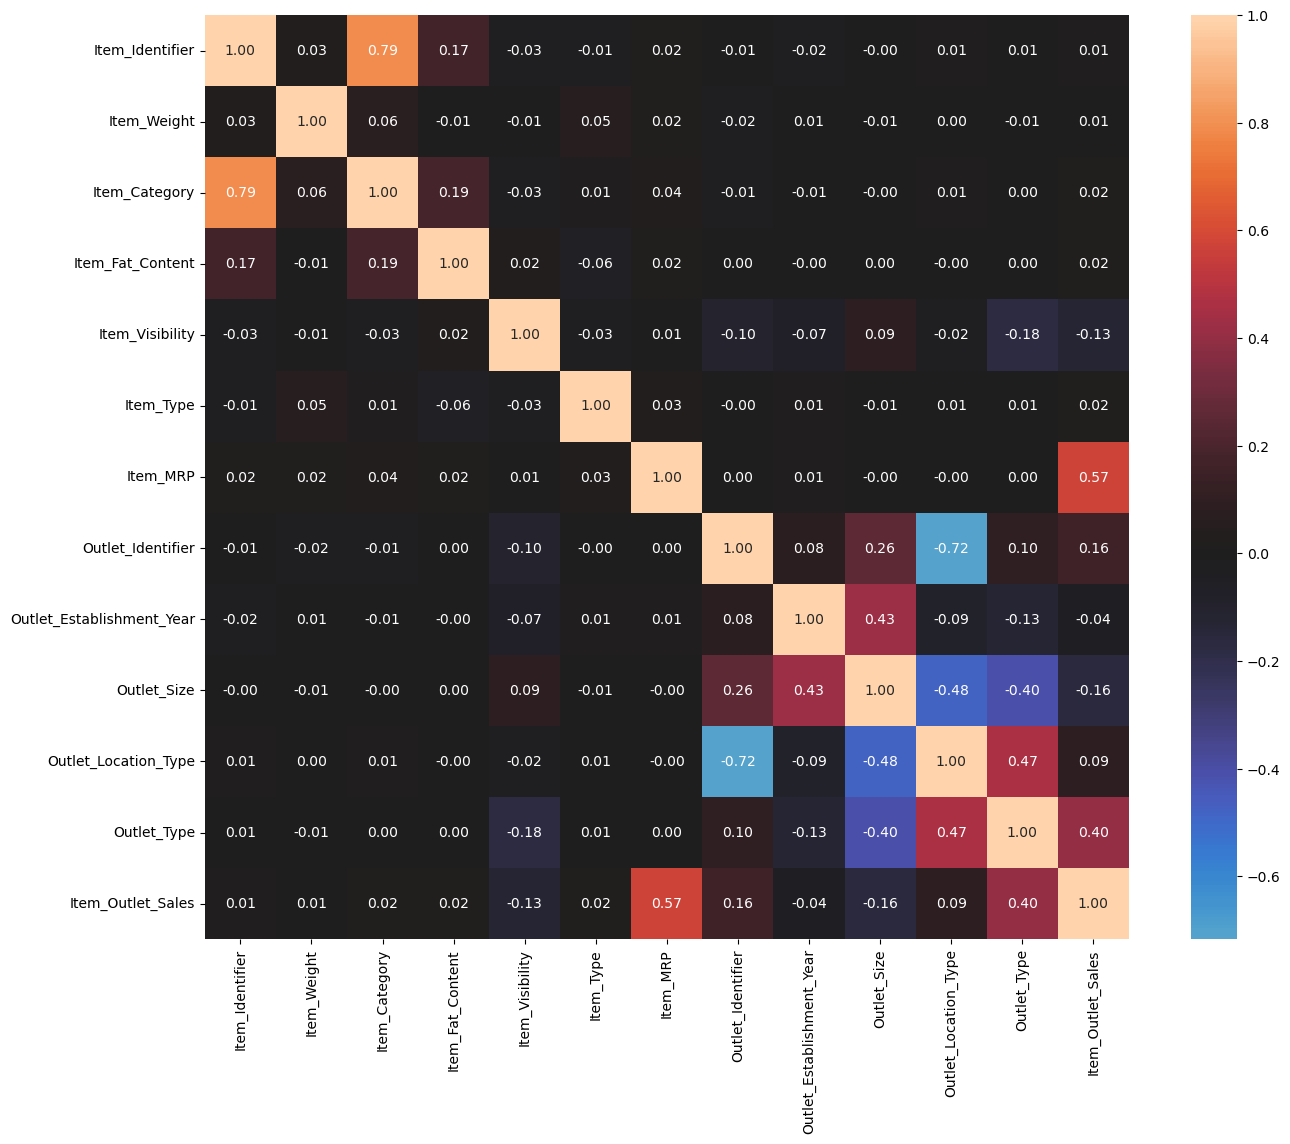

In [58]:
plt.figure(figsize=(16,12))
sns.heatmap(X2_train.corr(), center=0, annot=True, 
                fmt='.2f', square=True)

In [59]:
X=X2_train.iloc[:,:-1]

In [60]:
lreg = LinearRegression()
sfs1 = sfs(lreg, n_features_to_select=10)
sfs1 = sfs1.fit(X, y_train)

In [61]:
feat_status=list(sfs1.get_support())

In [62]:
feat_status

[False, True, True, True, True, True, True, True, False, True, True, True]

In [63]:
feat_names = list(sfs1.feature_names_in_)
print(feat_names)

['Item_Identifier', 'Item_Weight', 'Item_Category', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [64]:
feat_list1=dict(zip(feat_names,feat_status))
print(feat_list1)

{'Item_Identifier': False, 'Item_Weight': True, 'Item_Category': True, 'Item_Fat_Content': True, 'Item_Visibility': True, 'Item_Type': True, 'Item_MRP': True, 'Outlet_Identifier': True, 'Outlet_Establishment_Year': False, 'Outlet_Size': True, 'Outlet_Location_Type': True, 'Outlet_Type': True}


In [65]:
sfs1_2 = sfs(lreg, n_features_to_select=10,direction='backward')
sfs1_2 = sfs1_2.fit(X, y_train)
feat_names1_2 = list(sfs1_2.feature_names_in_)
feat_status1_2=list(sfs1_2.get_support())
feat_list1_2=dict(zip(feat_names1_2,feat_status1_2))
print(feat_list1_2)

{'Item_Identifier': True, 'Item_Weight': False, 'Item_Category': True, 'Item_Fat_Content': True, 'Item_Visibility': True, 'Item_Type': True, 'Item_MRP': True, 'Outlet_Identifier': True, 'Outlet_Establishment_Year': False, 'Outlet_Size': True, 'Outlet_Location_Type': True, 'Outlet_Type': True}


In [66]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
sfs2 = sfs(regr, n_features_to_select=10)
sfs2 = sfs2.fit(X, y_train)
feat_names1 = list(sfs2.feature_names_in_)
feat_status1=list(sfs2.get_support())
feat_list2=dict(zip(feat_names1,feat_status1))
print(feat_list2)

{'Item_Identifier': True, 'Item_Weight': True, 'Item_Category': True, 'Item_Fat_Content': True, 'Item_Visibility': True, 'Item_Type': True, 'Item_MRP': True, 'Outlet_Identifier': True, 'Outlet_Establishment_Year': False, 'Outlet_Size': False, 'Outlet_Location_Type': True, 'Outlet_Type': True}


In [67]:
sfs2_2 = sfs(regr, n_features_to_select=10,direction='backward')
sfs2_2 = sfs2_2.fit(X, y_train)
feat_names2_2 = list(sfs2_2.feature_names_in_)
feat_status2_2=list(sfs2_2.get_support())
feat_list2_2=dict(zip(feat_names2_2,feat_status2_2))
print(feat_list2_2)

{'Item_Identifier': False, 'Item_Weight': True, 'Item_Category': True, 'Item_Fat_Content': False, 'Item_Visibility': True, 'Item_Type': True, 'Item_MRP': True, 'Outlet_Identifier': True, 'Outlet_Establishment_Year': True, 'Outlet_Size': True, 'Outlet_Location_Type': True, 'Outlet_Type': True}


In [68]:
feat_list_combined=[feat_list1,feat_list1_2,feat_list2,feat_list2_2]

In [69]:
df1=pd.DataFrame(feat_list_combined,index=['Lr_f','Lr_b','Rf_f','Rf_b'])

In [70]:
df2=df1.T
df2['Sum_of_row'] = df2.loc[ : , :].sum(axis = 1)
df2

,Lr_f,Lr_b,Rf_f,Rf_b,Sum_of_row
Item_Identifier,False,True,True,False,2
Item_Weight,True,False,True,True,3
Item_Category,True,True,True,True,4
Item_Fat_Content,True,True,True,False,3
Item_Visibility,True,True,True,True,4
Item_Type,True,True,True,True,4
Item_MRP,True,True,True,True,4
Outlet_Identifier,True,True,True,True,4
Outlet_Establishment_Year,False,False,False,True,1
Outlet_Size,True,True,False,True,3
